In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


### Checking for missing values

In [3]:
df.isna().sum()

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

### Checking various categories to see if there is variability in columns that can be explored for information

In [4]:
df['category'].value_counts()

worldnews    509236
Name: category, dtype: int64

In [5]:
df['down_votes'].value_counts()

0    509236
Name: down_votes, dtype: int64

### The columns, 'down_votes' and 'category' have only one type of entry hence carry no information. (all texts have 0 down_vote and all categories are worldnews) and are dropped

In [6]:
usage_info = df.drop(columns=['title','time_created','category','down_votes'])
usage_info.head()

,date_created,up_votes,over_18,author
0,2008-01-25,3,False,polar
1,2008-01-25,2,False,polar
2,2008-01-25,3,False,polar
3,2008-01-25,1,False,fadi420
4,2008-01-25,4,False,mhermans


### Checking counting the number of posts for each category in the over_18 category. 

In [7]:
up_votes_df = usage_info.groupby('over_18',as_index=False).count()[['over_18','up_votes']].rename(columns={'up_votes':'Number of Posts'})
up_votes_df

,over_18,Number of Posts
0,False,508916
1,True,320


In [182]:
px.bar(up_votes_df, x='over_18',y='Number of Posts', height=500, width=1200)

### Reformatting the Date Created column so analysis can be made on the new posted on monthly basis

In [9]:
usage_info['Month Posted'] = pd.to_datetime(usage_info['date_created']).dt.month
usage_info['date_created'] = pd.to_datetime(usage_info['date_created']).dt.strftime('%Y-%m')
usage_info.head()

,date_created,up_votes,over_18,author,Month Posted
0,2008-01,3,False,polar,1
1,2008-01,2,False,polar,1
2,2008-01,3,False,polar,1
3,2008-01,1,False,fadi420,1
4,2008-01,4,False,mhermans,1


### Checking the total number of posts made in each month

In [10]:
monthly_df = usage_info.groupby('Month Posted', as_index=False).count()
monthly_df.head()

,Month Posted,date_created,up_votes,over_18,author
0,1,40258,40258,40258,40258
1,2,41518,41518,41518,41518
2,3,45651,45651,45651,45651
3,4,43363,43363,43363,43363
4,5,41826,41826,41826,41826


In [180]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
px.bar(monthly_df,x=months, y='date_created', title='Number of Posts per Month', height=500, width=1200)

### Grouping the number number of posts to check the trend of posts in terms of numbers over the years

In [12]:
trend_df = usage_info.groupby('date_created',as_index=False).count()
trend_df.head()

,date_created,up_votes,over_18,author,Month Posted
0,2008-01,18,18,18,18
1,2008-02,622,622,622,622
2,2008-03,1922,1922,1922,1922
3,2008-04,2649,2649,2649,2649
4,2008-05,2786,2786,2786,2786


### Plotting the trend of the number of posts made over the years which shows a growing number of posts.

In [ ]:
px.line(trend_df, x='date_created',y='up_votes', title='Trend of Number of Posts Over The Years', 
        labels={'up_votes': 'Number of User Activity', 'date_created': 'Date'},height=500, width=1200)

### Extracting only the text data for analysis

In [111]:
text_data = df['title']

#### WORKING WITH THE TEXT DATA

In [16]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
# np.random.seed(2018)
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tetteh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
text_data.head() #= text_data.map(lambda x:re.sub('[,\,.!?:;-]','',x))

0                  Scores killed in Pakistan clashes
1                   Japan resumes refuelling mission
2                    US presses Egypt on Gaza border
3       Jump-start economy: Give health care to all 
4    Council of Europe bashes EU&UN terror blacklist
Name: title, dtype: object

### Preprocessing the text

In [18]:
def lemmatize_stemming(text):
    #stemming and lemmatizing
    return PorterStemmer().stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    #looping through the different words in a given row 
    if gensim.utils.simple_preprocess(text):
        for token in gensim.utils.simple_preprocess(text):
            # taking out stopwords and all words longer than 2 letters then applying stemming and lemmatization
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >= 3:
                result.append(lemmatize_stemming(token))
    return result

In [19]:
processed_text = text_data.apply(preprocess)
processed_text

0                            [score, kill, pakistan, clash]
1                           [japan, resum, refuel, mission]
2                              [press, egypt, gaza, border]
3                      [jump, start, economi, health, care]
4                 [council, europ, bash, terror, blacklist]
                                ...                        
509231    [heil, trump, donald, trump, alt, right, white...
509232                    [peopl, specul, madelein, mccann]
509233           [professor, receiv, arab, research, award]
509234    [nigel, farag, attack, respons, trump, ambassa...
509235    [palestinian, wield, knife, shoot, dead, west,...
Name: title, Length: 509236, dtype: object

In [20]:
word_cloud = str(list(processed_text))

### Visualizing the most frequent words used in the news

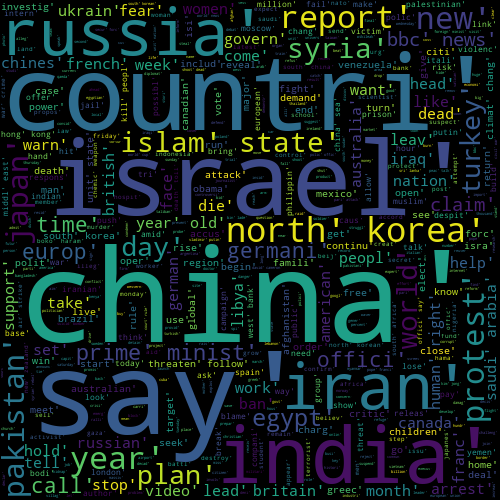

In [21]:
WordCloud(max_words=500, width=500, height=500).generate(word_cloud).to_image()

In [22]:
dictionary = gensim.corpora.Dictionary(processed_text)

In [ ]:
# count = 0
# for k, v in dictionary.iteritems():
#     print(k, v)
#     count += 1
#     if count > 10:
#         break


In [35]:
dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=1000000)

In [36]:
## Creating a bag of words
bo_words = [dictionary.doc2bow(doc) for doc in processed_text]

In [37]:
len(bo_words)

509236

In [38]:
#Selecting a row to see what is in the bag for that row
for i in range(len(bo_words[1])):
    print("Word number {} (\"{}\") appears {} times.".format(bo_words[1][i][0], 
                                               dictionary[bo_words[1][i][0]], 
bo_words[1][i][1]))

Word number 4 ("japan") appears 1 times.
Word number 5 ("mission") appears 1 times.
Word number 6 ("refuel") appears 1 times.
Word number 7 ("resum") appears 1 times.


### Building the LDA model to create topic clusters

In [45]:
lda_model = gensim.models.LdaMulticore(bo_words, num_topics=3, id2word=dictionary, passes=10, workers=3)

In [46]:
LDAvis_prepared = gensimvis.prepare(lda_model, bo_words, dictionary)

In [47]:
# pyLDAvis.save_html(LDAvis_prepared, 'ldavis_vis_'+ str(3) +'.html')
LDAvis_prepared.topic_info

,Term,Freq,Total,Category,logprob,loglift
271,china,30617.000000,30617.000000,Default,30.0000,30.0000
233,russia,21754.000000,21754.000000,Default,29.0000,29.0000
3209,syria,19839.000000,19839.000000,Default,28.0000,28.0000
908,polic,18873.000000,18873.000000,Default,27.0000,27.0000
978,presid,16202.000000,16202.000000,Default,26.0000,26.0000
...,...,...,...,...,...,...
116,leader,9226.239593,11703.818205,Topic3,-5.1058,0.8870
206,attack,13161.177685,27530.759554,Topic3,-4.7505,0.3868
1498,islam,8362.916705,12118.681600,Topic3,-5.2040,0.7539
1420,south,7892.194947,13765.840290,Topic3,-5.2619,0.5685


In [48]:
pyLDAvis.display(LDAvis_prepared)

#### Topic 0  tokens
Topic 0 seems to be centred around international trade relations, finance, and climate change

In [49]:
np.array(LDAvis_prepared.token_table[LDAvis_prepared.token_table['Topic']==1].sort_values('Freq', ascending=False)['Term']).T

array(['china', 'japan', 'world', 'record', 'brazil', 'water', 'climat',
       'chines', 'trade', 'largest', 'billion', 'million', 'chang',
       'scientist', 'cut', 'oil', 'rise', 'global', 'drug', 'market',
       'compani', 'food', 'greec', 'tax', 'energi', 'studi', 'island',
       'africa', 'research', 'fund', 'sea', 'olymp', 'caus', 'brexit',
       'mexico', 'bank', 'power', 'india', 'europ', 'time', 'new',
       'countri', 'year', 'nation', 'warn', 'plan', 'south', 'peopl',
       'ban', 'report', 'govern', 'death', 'say', 'offici', 'german',
       'british', 'state', 'minist', 'children', 'pari', 'french',
       'refuge'], dtype=object)

### Topic 1 tokens
Topic 1 seems to be centered around human right and civil unrests.

In [50]:
np.array(LDAvis_prepared.token_table[LDAvis_prepared.token_table['Topic']==2].sort_values('Freq', ascending=False)['Term']).T

array(['court', 'right', 'women', 'bbc', 'polic', 'school', 'charg',
       'saudi', 'video', 'muslim', 'law', 'arrest', 'man', 'old', 'crash',
       'terror', 'murder', 'sentenc', 'jail', 'abus', 'suspect',
       'investig', 'woman', 'alleg', 'famili', 'prison', 'arabia',
       'crime', 'sex', 'journalist', 'plane', 'pari', 'news', 'children',
       'british', 'german', 'french', 'anti', 'death', 'protest', 'ban',
       'attack', 'year', 'peopl', 'report', 'govern', 'kill', 'islam',
       'india', 'offici', 'time', 'say', 'leader', 'isi', 'nation', 'new',
       'bomb', 'state', 'forc', 'plan', 'countri', 'mexico', 'refuge',
       'brexit', 'minist', 'caus', 'warn', 'olymp', 'chines', 'war',
       'world'], dtype=object)

### Topic 2 tokens
Topic 2 seems to be centered around terrorism and news about international war

In [52]:
np.array(LDAvis_prepared.token_table[LDAvis_prepared.token_table['Topic']==3].sort_values('Freq', ascending=False)['Term']).T

array(['russia', 'ukrain', 'syria', 'strike', 'border', 'presid',
       'turkey', 'syrian', 'korea', 'north', 'militari', 'iraq', 'israel',
       'peac', 'isra', 'yemen', 'russian', 'obama', 'iran', 'missil',
       'putin', 'troop', 'war', 'palestinian', 'talk', 'rebel', 'elect',
       'armi', 'milit', 'iraqi', 'refuge', 'minist', 'forc', 'bomb',
       'isi', 'leader', 'state', 'islam', 'kill', 'south', 'offici',
       'say', 'warn', 'attack', 'plan', 'govern', 'report', 'countri',
       'nation', 'europ', 'protest', 'anti', 'power', 'french', 'new',
       'peopl', 'bank', 'time', 'news', 'sea', 'crime', 'brexit', 'ban',
       'saudi', 'year'], dtype=object)

### Classifying the topics of each news title

In [53]:
def topic_pred(bow):
    (topic0,topic0_prob),(topic1,topic1_prob),(topic2,topic2_prob)=lda_model.get_document_topics(bow,minimum_probability=0)

    return np.argmax([topic0_prob,topic1_prob,topic2_prob])

In [54]:
bow_df = pd.DataFrame({'Bag_Of_Words': bo_words})

In [55]:
bow_df['Topic'] = bow_df['Bag_Of_Words'].apply(topic_pred)

In [56]:
usage_info['Topic_Num'] = bow_df['Topic']
usage_info.head()

,date_created,up_votes,over_18,author,Month Posted,Topic_Num
0,2008-01,3,False,polar,1,2
1,2008-01,2,False,polar,1,0
2,2008-01,3,False,polar,1,2
3,2008-01,1,False,fadi420,1,0
4,2008-01,4,False,mhermans,1,1


In [57]:
num_posts_trend = usage_info.groupby(['date_created','Topic_Num'],as_index=False).count()[['date_created','Topic_Num','up_votes']]
num_posts_trend = num_posts_trend.rename(columns = {'up_votes':'Num_posts'})
num_posts_trend.head()

,date_created,Topic_Num,Num_posts
0,2008-01,0,6
1,2008-01,1,5
2,2008-01,2,7
3,2008-02,0,194
4,2008-02,1,266


### Vissualizing the trend in number of posts over the time period

In [63]:
px.line(num_posts_trend, x='date_created', y='Num_posts', color = 'Topic_Num', labels={'Num_posts':'Number of Posts', 'date_created':'Date'}
       ,height=500, width=1200)

In [60]:
num_upvotes_trend = usage_info.groupby(['date_created','Topic_Num'],as_index=False).sum()[['date_created','Topic_Num','up_votes']]
num_upvotes_trend = num_upvotes_trend.rename(columns={'up_votes':'Num_Upvotes'})
num_upvotes_trend.head()

,date_created,Topic_Num,Num_Upvotes
0,2008-01,0,8
1,2008-01,1,29
2,2008-01,2,33
3,2008-02,0,904
4,2008-02,1,1531


### The number of upvotes over time

In [62]:
px.line(num_upvotes_trend, x='date_created', y='Num_Upvotes', color = 'Topic_Num', labels={'Num_Upvotes':'Number of Upvotes', 'date_created':'Date'},
       height=500, width=1200)

In [64]:
upvotes_per_post = num_upvotes_trend.merge(num_posts_trend, how='left', on = ['date_created','Topic_Num'])
upvotes_per_post['Upvotes_Per_Post'] = upvotes_per_post['Num_Upvotes']/upvotes_per_post['Num_posts']
upvotes_per_post.head()

,date_created,Topic_Num,Num_Upvotes,Num_posts,Upvotes_Per_Post
0,2008-01,0,8,6,1.333333
1,2008-01,1,29,5,5.800000
2,2008-01,2,33,7,4.714286
3,2008-02,0,904,194,4.659794
4,2008-02,1,1531,266,5.755639


### Number of upvotes per post over the year (to view the average reaction to the different types of new over time)

In [65]:
px.line(upvotes_per_post, x='date_created', y='Upvotes_Per_Post', color='Topic_Num',
        labels={'Upvotes_Per_Post': 'Upvotes Per Post', 'date_created':'Number of Posts'}, height=500, width=1200)

### Total number of news posts per topic cluster 

In [67]:
px.bar(usage_info.groupby('Topic_Num',as_index=False).count(), 
       x='Topic_Num', y='over_18', labels={'Topic_Num': 'Topic Cluster', 'over_18':'Number of Posts'}, height=500, width=1200)

### Total Number of upvotes per news topic cluster

In [68]:
px.bar(usage_info.groupby('Topic_Num',as_index=False).sum(), x='Topic_Num', y='up_votes', 
       labels={'Topic_Num': 'Topic Cluster', 'over_18':'Number of Upvotes'}, height=500, width=1200)

### Function to categorize the titles into two classes, i.e High upvote posts and Low upvote posts for each title. 
### The box plot is used to create the categories with the outliers above the upper fence implying they tend to have very 
### high reactions while the others are classified as normal/low reaction

In [76]:
# px.box(usage_info, x='up_votes', title='Boxplot of Upvotes on Each Post', height=500, width=1200)

In [71]:
# the upper fence of 38 is used as the boundary
def upvote_cat(votes):
    if votes>38:
        return "high"
    return "low"

In [72]:
# Transforming the text to vectors
X = TfidfVectorizer(min_df=0.002,stop_words=gensim.parsing.preprocessing.STOPWORDS, tokenizer=preprocess).fit_transform(text_data)

In [73]:
print(X[10])

  (0, 591)	0.6040354187846927
  (0, 863)	0.48253982776834614
  (0, 482)	0.5024486683556599
  (0, 569)	0.387094126974977


In [113]:
text_data = pd.DataFrame(text_data)

In [114]:
usage_info['Categorical Upvote'] = usage_info['up_votes'].apply(upvote_cat)

In [115]:
text_data['Categorical Upvote'] = usage_info['Categorical Upvote'] 

### Creating a balanced dataset by downsampling the Categorical Upvote Low class

In [132]:
balanced_data = shuffle(pd.concat([text_data[text_data['Categorical Upvote']=='low'].sample(80000),
                                   text_data[text_data['Categorical Upvote']=='high']])).reset_index()
balanced_data['Categorical Upvote'].value_counts()

low     80000
high    79068
Name: Categorical Upvote, dtype: int64

### Creating a dummy variable using the two classes and picking the 'High' class meaning 0 means 'Low' and 1 means 'High'

In [133]:
balanced_X = balanced_data['title']
balanced_y = pd.get_dummies(balanced_data['Categorical Upvote'])['high']

In [134]:
X_balanced = TfidfVectorizer(min_df=0.001,stop_words=gensim.parsing.preprocessing.STOPWORDS, tokenizer=preprocess).fit_transform(balanced_X)

In [135]:
px.bar(usage_info.groupby('Categorical Upvote', as_index=False).count(), 
       x='Categorical Upvote', y='date_created',opacity=1, labels={'date_created':'Number of Posts'}, height=500, width=1200, title='Imbalanced Data')

In [136]:
px.bar(balanced_data.groupby('Categorical Upvote', as_index=False).count(), 
       x='Categorical Upvote', y='index',opacity=1, labels={'index':'Number of Posts'}, height=500, width=1200, title='Balanced Data')

In [143]:
y = pd.get_dummies(usage_info['Categorical Upvote'])
y_used = y['high']
y_used.head()

0    0
1    0
2    0
3    0
4    0
Name: high, dtype: uint8

### Splitting the data into train and test set

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,y_used, random_state = 42, test_size = 0.25)

In [146]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced,balanced_y, random_state = 42, test_size = 0.25)

### Building a Random Forest Classifier

In [148]:
## Building a random forest classifier 
from sklearn.ensemble import RandomForestClassifier
rdcf = RandomForestClassifier()
rdcf.fit(X_train,y_train)
rdcf.score(X_test,y_test)

0.8376548397992286

In [150]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test,rdcf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91    107628
           1       0.23      0.02      0.04     19681

    accuracy                           0.84    127309
   macro avg       0.54      0.50      0.48    127309
weighted avg       0.75      0.84      0.78    127309



In [149]:
# fitting and testing on the balanced dataset
rdcf_bal = RandomForestClassifier()
rdcf_bal.fit(X_train_balanced,y_train_balanced)
rdcf_bal.score(X_test_balanced,y_test_balanced)

0.6121658661704429

In [157]:
print(classification_report(y_test_balanced,rdcf_bal.predict(X_test_balanced)))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61     20001
           1       0.61      0.62      0.61     19766

    accuracy                           0.61     39767
   macro avg       0.61      0.61      0.61     39767
weighted avg       0.61      0.61      0.61     39767



### Building and training Logistic Regression Model

In [154]:
#inbalanced classification
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train,y_train)
log.score(X_test,y_test)

0.8456354224760229

In [153]:
print(classification_report(y_test,log.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92    107628
           1       0.53      0.01      0.02     19681

    accuracy                           0.85    127309
   macro avg       0.69      0.50      0.47    127309
weighted avg       0.80      0.85      0.78    127309



In [155]:
log_bal = LogisticRegression()
log_bal.fit(X_train_balanced,y_train_balanced)
log_bal.score(X_train_balanced,y_train_balanced)

0.6449401094710019

In [156]:
print(classification_report(y_test_balanced,log_bal.predict(X_test_balanced)))

              precision    recall  f1-score   support

           0       0.63      0.64      0.64     20001
           1       0.63      0.62      0.62     19766

    accuracy                           0.63     39767
   macro avg       0.63      0.63      0.63     39767
weighted avg       0.63      0.63      0.63     39767



### Building and training a Gradient Boosting Classifier

In [159]:
from sklearn.ensemble import GradientBoostingClassifier
gboost = GradientBoostingClassifier()
gboost.fit(X_train,y_train)
gboost.score(X_test,y_test)

0.8455097440086718

In [160]:
print(classification_report(y_test,gboost.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92    107628
           1       0.67      0.00      0.00     19681

    accuracy                           0.85    127309
   macro avg       0.76      0.50      0.46    127309
weighted avg       0.82      0.85      0.78    127309



In [161]:
gboost_bal = GradientBoostingClassifier()
gboost_bal.fit(X_train_balanced,y_train_balanced)
gboost_bal.score(X_test_balanced,y_test_balanced)

0.5940604018407222

In [162]:
print(classification_report(y_test_balanced,gboost_bal.predict(X_test_balanced)))

              precision    recall  f1-score   support

           0       0.57      0.75      0.65     20001
           1       0.63      0.44      0.52     19766

    accuracy                           0.59     39767
   macro avg       0.60      0.59      0.58     39767
weighted avg       0.60      0.59      0.58     39767



### KNN

In [176]:
k_neigh = KNeighborsClassifier(n_neighbors=5)
k_neigh.fit(X_train,y_train)
train_acc = k_neigh.score(X_train,y_train)
test_acc = k_neigh.score(X_test,y_test)
print(f'Training accuracy is: {train_acc}')
print(f'Testing accuracy is: {test_acc}')

Training accuracy is: 0.8546371427000448
Testing accuracy is: 0.8355183058542601


In [178]:
print(classification_report(y_test,k_neigh.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91    107628
           1       0.25      0.03      0.06     19681

    accuracy                           0.84    127309
   macro avg       0.55      0.51      0.48    127309
weighted avg       0.75      0.84      0.78    127309



In [177]:
k_neigh_bal = KNeighborsClassifier(n_neighbors=5)
k_neigh_bal.fit(X_train_balanced,y_train_balanced)
train_acc_bal = k_neigh_bal.score(X_train_balanced,y_train_balanced)
test_acc_bal = k_neigh_bal.score(X_test_balanced,y_test_balanced)
print(f'Training accuracy is: {train_acc_bal}')
print(f'Testing accuracy is: {test_acc_bal}')

Training accuracy is: 0.6487707563222438
Testing accuracy is: 0.5218397163477255


In [179]:
print(classification_report(y_test_balanced,k_neigh_bal.predict(X_test_balanced)))

              precision    recall  f1-score   support

           0       0.52      0.80      0.63     20001
           1       0.54      0.24      0.33     19766

    accuracy                           0.52     39767
   macro avg       0.53      0.52      0.48     39767
weighted avg       0.53      0.52      0.48     39767

